# Import Independencies

In [2]:
# notebooks/03_Correlation_Analysis.ipynb

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob # For sentiment analysis

*Project set up importing reusable modules*

In [3]:
# --- Project Setup: Ensure src module is discoverable ---
# importing from src.config
def find_project_root(current_path):
    """
    Finds the project root by looking for common project directories.
    Assumes project_root contains 'src', 'data', and 'notebooks'.
    """
    path = current_path
    while path != os.path.dirname(path):
        if (os.path.isdir(os.path.join(path, 'src')) and
            os.path.isdir(os.path.join(path, 'data')) and
            os.path.isdir(os.path.join(path, 'notebooks'))):
            return path
        path = os.path.dirname(path)
    return current_path # Fallback if no specific root found

current_working_dir = os.getcwd()
project_root = find_project_root(current_working_dir)

if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to sys.path for module imports.")
else:
    print(f"'{project_root}' already in sys.path.")

# Import configuration variables from your src.config
from src.config import NEWS_RAW_PATH, STOCK_DATA_DIR, STOCK_TICKERS


Added 'c:\Users\hp\OneDrive\Desktop\kaim-ai\KAIM-1\NewsSentiment-StockPrice-Prediction' to sys.path for module imports.
Project structure setup complete and config.py created/updated.
Base Directory: c:\Users\hp\OneDrive\Desktop\kaim-ai\KAIM-1\NewsSentiment-StockPrice-Prediction
News Raw Path: c:\Users\hp\OneDrive\Desktop\kaim-ai\KAIM-1\NewsSentiment-StockPrice-Prediction\data\raw_analyst_ratings.csv
Stock Data Directory: c:\Users\hp\OneDrive\Desktop\kaim-ai\KAIM-1\NewsSentiment-StockPrice-Prediction\data\yfinance_data
Tickers to process: ['AAPL', 'AMZN', 'GOOG', 'META', 'NVDA', 'TSLA']


In [4]:

print("\n--- Starting Task 3: Correlation Analysis ---")

# --- Load News Data ---
print("\n--- Loading News Data ---")
try:
    # Ensure this is the only place news_df is loaded/modified for now
    news_df = pd.read_csv(NEWS_RAW_PATH) # Do NOT parse_dates here, handle it in next step
    print("News data loaded successfully.")
    print(f"News DataFrame Info (initial load): {news_df.info()}")
    print("\nFirst 5 rows of News data (initial load):")
    print(news_df.head())
except FileNotFoundError:
    print(f"CRITICAL ERROR: News data file not found at {NEWS_RAW_PATH}.")
    sys.exit("Exiting: News data file not found.")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load news data: {e}")
    sys.exit("Exiting: News data loading failed.")

if news_df.empty:
    sys.exit("Exiting: News DataFrame is empty after loading.")


# --- Load Stock Data (for a single ticker to start, e.g., AMZN) ---
print("\n--- Loading Stock Data (e.g., AMZN) ---")
ticker_to_analyze = 'AMZN' # Choose a specific ticker for correlation analysis
stock_file_name = f"{ticker_to_analyze}_historical_data.csv"
stock_file_path = os.path.join(STOCK_DATA_DIR, stock_file_name)

try:
    stock_df = pd.read_csv(stock_file_path, parse_dates=True, index_col='Date')
    stock_df.columns = [col.replace(' ', '_') for col in stock_df.columns]
    if 'Adj_Close' in stock_df.columns and 'Close' not in stock_df.columns:
        stock_df['Close'] = stock_df['Adj_Close']
    stock_df.dropna(inplace=True)
    print(f"Stock data for {ticker_to_analyze} loaded successfully.")
    print("Stock DataFrame Info:")
    stock_df.info()
    print("\nFirst 5 rows of Stock data:")
    print(stock_df.head())
except FileNotFoundError:
    print(f"CRITICAL ERROR: Stock data file not found at {stock_file_path}.")
    sys.exit("Exiting: Stock data file not found.")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load stock data: {e}")
    sys.exit("Exiting: Stock data loading failed.")

if stock_df.empty:
    sys.exit("Exiting: Stock DataFrame is empty after loading.")

# --- Date Alignment ---
print("\n--- Aligning News and Stock Data by Date ---")

# Store original length for comparison
original_total_news_rows = len(news_df)
print(f"Original news_df rows at start of alignment process: {original_total_news_rows}")


# 1. Process News DataFrame 'date' column
# Step 1.1: Convert to datetime, coercing errors, and using 'mixed' format.
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce', format='mixed')
print(f"news_df rows after pd.to_datetime (before initial dropna): {len(news_df)}")


# Step 1.2: IMMEDIATELY drop rows where date conversion failed (became NaT)
# This is CRITICAL. Any NaT values will prevent .dt accessor from working.
rows_before_initial_dropna = len(news_df)
news_df.dropna(subset=['date'], inplace=True)
rows_after_initial_dropna = len(news_df)
if rows_after_initial_dropna < rows_before_initial_dropna:
    print(f"Dropped {rows_before_initial_dropna - rows_after_initial_dropna} rows due to unparseable dates after initial conversion.")
else:
    print("No rows dropped during initial date conversion and dropna.")
print(f"news_df rows after initial dropna: {len(news_df)}")

# --- CRITICAL FIX: Ensure dtype is datetime64[ns] after coercion and dropna ---
# If news_df['date'] is still 'object' dtype, it means some values couldn't be converted
# even after errors='coerce', or it's mixed with non-datetime objects.
# We explicitly cast it. This might introduce new NaNs if there are unconvertible types.
# We also want it to be timezone-naive (datetime64[ns]) before the timezone logic.
try:
    # First, ensure it's a generic datetime type, then convert to UTC and make naive
    # Handle potentially timezone-aware data first before forcing naive.
    if pd.api.types.is_datetime64_any_dtype(news_df['date']):
        # If it's already a datetime type, check for timezone and standardize
        if news_df['date'].dt.tz is not None:
            news_df['date'] = news_df['date'].dt.tz_convert('UTC')
            print("News dates were timezone-aware, converted to UTC.")
        else:
            # If naive, localize to UTC (assuming they are implicitly UTC or local times to be treated as UTC)
            news_df['date'] = news_df['date'].dt.tz_localize('UTC', errors='coerce')
            print("News dates were timezone-naive, localized to UTC.")
        
        # Finally, strip the timezone information to get a naive datetime object representing UTC date
        news_df['date'] = news_df['date'].dt.tz_localize(None)
        print("News dates converted to timezone-naive UTC representation for daily alignment.")
        
    else:
        # If it's not a datetime dtype yet, it must be 'object'. Try to convert again explicitly to datetime64[ns, UTC]
        # and then make naive. This is a failsafe.
        news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce', utc=True)
        news_df['date'] = news_df['date'].dt.tz_localize(None) # Then strip timezone
        print("News dates forced to datetime and converted to timezone-naive UTC representation.")

except Exception as e:
    print(f"Error during explicit datetime type conversion: {e}")
    # If conversion still fails, drop rows that couldn't be converted
    news_df.dropna(subset=['date'], inplace=True)

# Drop NaNs again after timezone standardization/explicit conversion in case new NaTs were introduced
current_rows = len(news_df)
news_df.dropna(subset=['date'], inplace=True)
if len(news_df) < current_rows:
    print(f"Dropped {current_rows - len(news_df)} rows from news_df after full datetime standardization due to new NaTs.")
else:
    print("No additional rows dropped after full datetime standardization.")
print(f"news_df rows after full datetime standardization: {len(news_df)}")

# VERIFY DTYPE AGAIN BEFORE .dt.floor('D')
print(f"news_df['date'] dtype AFTER all timezone standardization: {news_df['date'].dtype}")
if not pd.api.types.is_datetime64_any_dtype(news_df['date']):
    print("CRITICAL: 'date' column is NOT datetime dtype after standardization. Cannot proceed with .dt accessor.")
    sys.exit("Exiting: 'date' column not datetime type.")
print(f"Final news_df rows before floor/set_index: {len(news_df)}") # Final check before setting index


# Step 1.5: Extract only the date part (YYYY-MM-DD) for daily alignment
# This line should now work without AttributeError
news_df['date_only'] = news_df['date'].dt.floor('D') # Floors to the start of the day
print("Successfully extracted date_only column.")

# Step 1.6: Set 'date_only' as the index for news_df for merging
news_df.set_index('date_only', inplace=True)
news_df.sort_index(inplace=True)
print(f"news_df rows after setting index: {len(news_df)}")


# 2. Process Stock DataFrame Index
stock_df.index = stock_df.index.floor('D') # Floors to the start of the day
stock_df.sort_index(inplace=True)
print(f"stock_df rows after floor: {len(stock_df)}")


# 3. Aggregate news headlines by date (if multiple on same day) BEFORE merging
if 'headline' not in news_df.columns:
    print("CRITICAL ERROR: 'headline' column not found in news_df. Please check your news data.")
    sys.exit("Exiting: Missing 'headline' column.")

daily_news_headlines = news_df.groupby(news_df.index)['headline'].apply(lambda x: ' '.join(x)).rename('combined_headline')
print(f"daily_news_headlines series length: {len(daily_news_headlines)}")

print("\nCombined Daily News Headlines (first 5 entries):")
print(daily_news_headlines.head())


# 4. Merge aggregated daily news headlines with daily stock data
merged_df = pd.merge(
    stock_df,
    daily_news_headlines,
    left_index=True,
    right_index=True,
    how='inner'
)

print(f"\nMerged DataFrame shape after date alignment and headline aggregation: {merged_df.shape}")
print("\nFirst 5 rows of Merged data:")
print(merged_df.head())

if merged_df.empty:
    sys.exit("Exiting: Merged DataFrame is empty. No common dates found between news and stock data after alignment.")

# ... (rest of your sentiment analysis, correlation, visualization code remains the same)


--- Starting Task 3: Correlation Analysis ---

--- Loading News Data ---
News data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
News DataFrame Info (initial load): None

First 5 rows of News data (initial load):
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In 

C:\Users\hp\AppData\Local\Temp\ipykernel_1032\1747959785.py:60: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce', format='mixed')


news_df rows after pd.to_datetime (before initial dropna): 1407328
No rows dropped during initial date conversion and dropna.
news_df rows after initial dropna: 1407328
News dates forced to datetime and converted to timezone-naive UTC representation.
No additional rows dropped after full datetime standardization.
news_df rows after full datetime standardization: 1407328
news_df['date'] dtype AFTER all timezone standardization: datetime64[ns]
Final news_df rows before floor/set_index: 1407328
Successfully extracted date_only column.
news_df rows after setting index: 1407328
stock_df rows after floor: 6846
daily_news_headlines series length: 3955

Combined Daily News Headlines (first 5 entries):
date_only
2009-02-14                         How Treasuries and ETFs Work
2009-04-27    Update on the Luxury Sector: 2nd Quarter 2009 ...
2009-04-29                               Going Against the Herd
2009-05-22    Charles Sizemore Radio Interview Saturday Morning
2009-05-27    JVA perks to 39% 

In [5]:


# --- Sentiment Analysis ---
print("\n--- Performing Sentiment Analysis on News Headlines ---")

# Ensure 'combined_headline' column exists. It should from the previous step.
if 'combined_headline' not in merged_df.columns:
    print("CRITICAL ERROR: 'combined_headline' column not found in merged_df. Please check previous steps.")
    sys.exit("Exiting: Missing 'combined_headline' column for sentiment analysis.")

# Function to get sentiment polarity using TextBlob
# TextBlob's polarity ranges from -1.0 (negative) to 1.0 (positive)
def get_sentiment_polarity(text):
    if pd.isna(text): # Handle NaN or missing text
        return 0.0 # Assign a neutral score for missing headlines
    return TextBlob(str(text)).sentiment.polarity

# Apply sentiment analysis to each combined headline
merged_df['sentiment_score'] = merged_df['combined_headline'].apply(get_sentiment_polarity)

print("\nMerged DataFrame with Sentiment Scores (last 5 rows):")
print(merged_df.tail())

print(f"Sentiment analysis completed. Added 'sentiment_score' column. Null sentiment scores: {merged_df['sentiment_score'].isnull().sum()}")

# Basic check on sentiment distribution
print("\nBasic sentiment score distribution:")
print(merged_df['sentiment_score'].describe())


--- Performing Sentiment Analysis on News Headlines ---

Merged DataFrame with Sentiment Scores (last 5 rows):
                  Open        High         Low       Close   Adj_Close  \
2020-06-05  122.225502  124.432503  121.856499  124.150002  124.150002   
2020-06-08  125.010002  126.500000  124.366997  126.203003  126.203003   
2020-06-09  126.472000  131.321503  126.250000  130.042999  130.042999   
2020-06-10  132.250000  136.117493  131.313004  132.372498  132.372498   
2020-06-11  130.175003  133.569000  126.811501  127.898003  127.898003   

               Volume  Dividends  Stock_Splits  \
2020-06-05   66128000        0.0           0.0   
2020-06-08   79414000        0.0           0.0   
2020-06-09  103520000        0.0           0.0   
2020-06-10   98920000        0.0           0.0   
2020-06-11  116002000        0.0           0.0   

                                            combined_headline  sentiment_score  
2020-06-05  77 Biggest Movers From Yesterday Shares of sev...

In [6]:
# notebooks/03_Correlation_Analysis.ipynb - New Cell

# --- Calculate Daily Stock Returns & Final Data Prep for Correlation ---
print("\n--- Calculating Daily Stock Returns & Preparing Data for Correlation ---")

# Calculate Daily Stock Returns
# Use .pct_change() to get percentage change from previous day
merged_df['Daily_Return'] = merged_df['Close'].pct_change()

# For correlation, we need to ensure both 'Daily_Return' and 'sentiment_score'
# are non-null and aligned.
# The 'sentiment_score' was created from 'combined_headline' which is per-day,
# so no further aggregation is needed for sentiment itself.
# We will drop NaNs that result from .pct_change() (the first day will be NaN)
# and any NaNs in sentiment_score (which should be 0.0 if handled by function).

# Create the DataFrame specifically for correlation analysis
correlation_df = merged_df[['Daily_Return', 'sentiment_score']].dropna()

print("\nDaily Stock Returns (last 5 entries):")
print(correlation_df['Daily_Return'].tail())

print("\nSentiment Scores in Correlation DataFrame (last 5 entries):")
print(correlation_df['sentiment_score'].tail())

print(f"\nCorrelation DataFrame shape: {correlation_df.shape}")
if correlation_df.empty:
    print("WARNING: Correlation DataFrame is empty after dropping NaNs. Cannot proceed with correlation analysis.")


--- Calculating Daily Stock Returns & Preparing Data for Correlation ---

Daily Stock Returns (last 5 entries):
2020-06-05    0.009103
2020-06-08    0.016536
2020-06-09    0.030427
2020-06-10    0.017913
2020-06-11   -0.033802
Name: Daily_Return, dtype: float64

Sentiment Scores in Correlation DataFrame (last 5 entries):
2020-06-05    0.156350
2020-06-08    0.119351
2020-06-09   -0.017079
2020-06-10   -0.040486
2020-06-11   -0.010033
Name: sentiment_score, dtype: float64

Correlation DataFrame shape: (2756, 2)


In [7]:
# notebooks/03_Correlation_Analysis.ipynb - New Cell

# --- Correlation Analysis ---
print("\n--- Performing Correlation Analysis ---")

if correlation_df.empty:
    print("WARNING: Correlation DataFrame is empty. Skipping correlation calculation.")
else:
    # Calculate Pearson correlation coefficient
    # .corr() method directly on DataFrame computes pairwise correlation
    correlation = correlation_df['Daily_Return'].corr(correlation_df['sentiment_score'])
    
    print(f"\nPearson Correlation between Average Daily News Sentiment and {ticker_to_analyze} Daily Returns: {correlation:.4f}")

    # Interpretation of correlation strength
    abs_correlation = abs(correlation)
    if abs_correlation >= 0.7:
        print("Interpretation: Strong correlation.")
    elif abs_correlation >= 0.5:
        print("Interpretation: Moderate correlation.")
    elif abs_correlation >= 0.3:
        print("Interpretation: Weak correlation.")
    else:
        print("Interpretation: Very weak or no linear correlation.")

    # Interpretation of direction
    if correlation > 0:
        print("Direction: Positive. Positive news sentiment tends to be associated with positive stock returns, and vice-versa.")
    elif correlation < 0:
        print("Direction: Negative. Positive news sentiment tends to be associated with negative stock returns, and vice-versa.")
    else:
        print("Direction: No linear relationship.")

    print("\nImportant Note: Correlation does not imply causation!")


--- Performing Correlation Analysis ---

Pearson Correlation between Average Daily News Sentiment and AMZN Daily Returns: 0.0597
Interpretation: Very weak or no linear correlation.
Direction: Positive. Positive news sentiment tends to be associated with positive stock returns, and vice-versa.

Important Note: Correlation does not imply causation!



--- Visualizing Sentiment vs. Returns ---


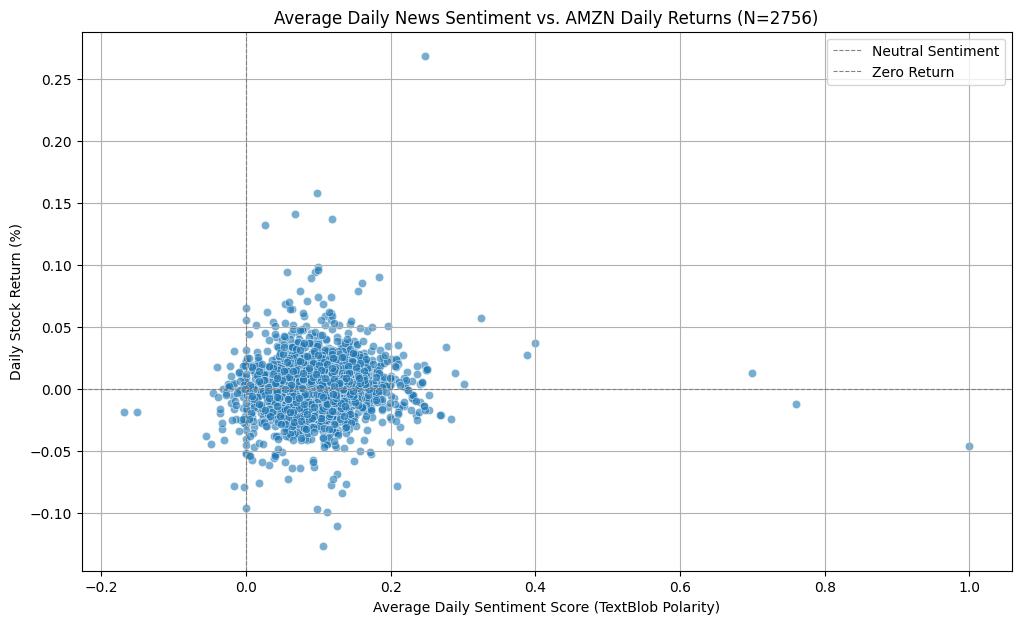

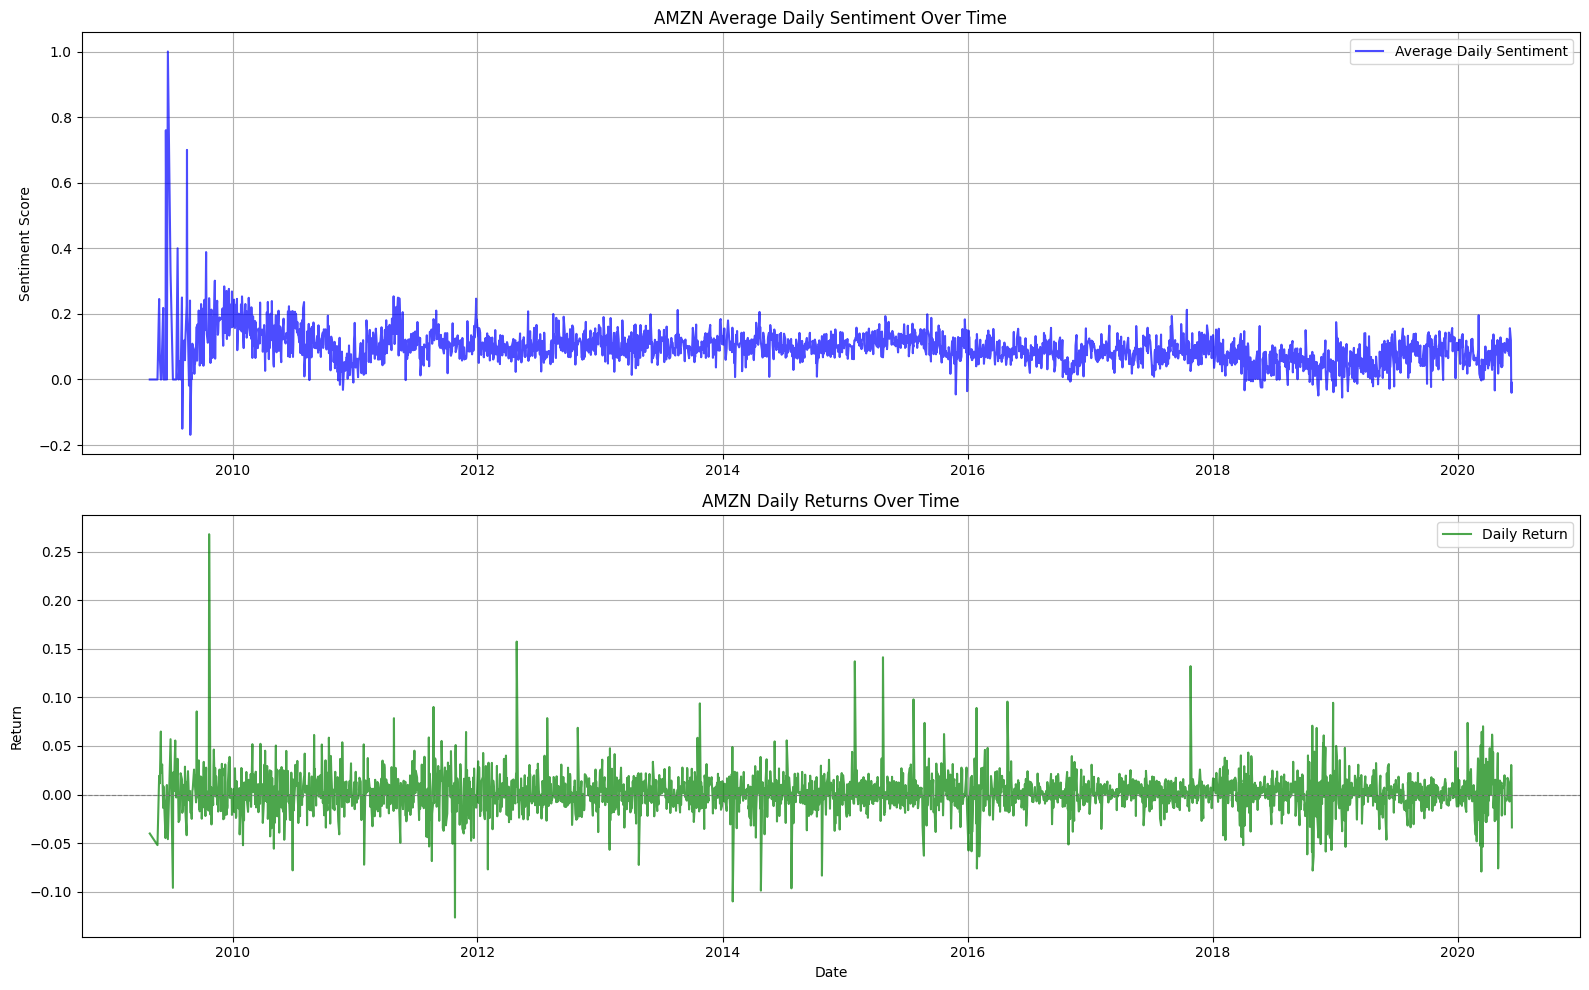


--- Correlation Analysis Complete ---


In [11]:
# notebooks/03_Correlation_Analysis.ipynb - New Cell

# --- Visualization of Correlation ---
print("\n--- Visualizing Sentiment vs. Returns ---")

if not correlation_df.empty:
    # Scatter Plot of Sentiment vs. Returns
    plt.figure(figsize=(12, 7))
    sns.scatterplot(x='sentiment_score', y='Daily_Return', data=correlation_df, alpha=0.6)
    plt.title(f'Average Daily News Sentiment vs. {ticker_to_analyze} Daily Returns (N={len(correlation_df)})')
    plt.xlabel('Average Daily Sentiment Score (TextBlob Polarity)')
    plt.ylabel('Daily Stock Return (%)') # Assuming returns are decimal, multiply by 100 for percentage
    plt.grid(True)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Neutral Sentiment') # Neutral sentiment line
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='Zero Return')       # Zero return line
    plt.legend()
    plt.show()

    # Time series plots of Sentiment and Returns
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 1, 1) # Top plot
    plt.plot(correlation_df.index, correlation_df['sentiment_score'], label='Average Daily Sentiment', color='blue', alpha=0.7)
    plt.title(f'{ticker_to_analyze} Average Daily Sentiment Over Time')
    plt.ylabel('Sentiment Score')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2) # Bottom plot
    plt.plot(correlation_df.index, correlation_df['Daily_Return'], label='Daily Return', color='green', alpha=0.7)
    plt.title(f'{ticker_to_analyze} Daily Returns Over Time')
    plt.ylabel('Return')
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Add a zero return line

    plt.tight_layout()
    plt.show()
else:
    print("No data available in correlation_df for plotting.")

print("\n--- Correlation Analysis Complete ---")
